[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/francisco-ortin/data-science-course/blob/main/deep-learning/cnn/hugging_face.ipynb)
[![License: CC BY-NC-SA 4.0](https://img.shields.io/badge/License-CC%20BY--NC--SA%204.0-lightgrey.svg)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

# Pretrained models

Training a deep model is computationally expensive and requires a lot of data. However, there are many pretrained models available that can be used for inference (use them directly) or transfer learning (fine-tune them with a small dataset). There are many pretrained models available on the Internet including sites such as [Hugging Face](https://huggingface.co/), [TensorFlow Hub](https://tfhub.dev/) and [PyTorch Hub](https://pytorch.org/hub/).

In this notebook, we will use a three CNN pretrained models from Hugging Face to classify images, perform object detection and image segmentation.


In [1]:
# make sure the required packages are installed
%pip install numpy matplotlib keras tensorflow transformers ultralyticsplus==0.0.23 ultralytics==8.0.21 --quiet
repo='data-science-course'
module='deep-learning/cnn'
# if running in colab, install the required packages and copy the necessary files
if get_ipython().__class__.__module__.startswith('google.colab'):
    import os
    if not os.path.exists(repo):
        !git clone --filter=blob:none --sparse https://github.com/francisco-ortin/data-science-course.git 2>/dev/null
        !cd {repo} && git sparse-checkout init --cone && git sparse-checkout set {module}  2>/dev/null
    !cp --update {repo}/{module}/*.py . 2>/dev/null
    !mkdir -p img data
    !mv {repo}/{module}/img/* img/. 2>/dev/null
    !mv {repo}/{module}/data/* data/. 2>/dev/null

from transformers import TFAutoModelForImageClassification, AutoFeatureExtractor
import tensorflow as tf
from PIL import Image
import requests
import matplotlib.pyplot as plt
from ultralyticsplus import YOLO, render_result
from transformers import SegformerImageProcessor, AutoModelForSemanticSegmentation
from PIL import Image
import requests
import torch.nn as nn

import images
import utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.6/113.6 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.3 MB/s eta 0:00:00


## Hugging Face

[Hugging Face](https://huggingface.co/) is a company and open-source community dedicated to artificial intelligence (AI). Founded in 2016, it is renowned for its `Transformers` library, which offers pre-trained models for a variety of tasks such as computer vision, audio processing and natural language processing. The Hugging Face Model Hub hosts thousands of these models, allowing users to easily download and integrate them into their applications. The community promotes collaboration and knowledge-sharing among researchers and developers.

In addition to the `Transformers` library, Hugging Face provides the Datasets library for accessing diverse datasets, along with user-friendly APIs that simplify complex model implementations. It also provides educational resources, including courses and tutorials.

## Image classification

The first CNN pretrained model we use is a [ResNet-50](https://huggingface.co/microsoft/resnet-50) model from Microsoft. We use it to classify images from the Internet. ResNet-50 is a convolutional neural network that is 50 layers deep. It is trained on the [ImageNet](https://www.image-net.org/) dataset, which contains millions of images across thousands of classes. The model has been fine-tuned to recognize a wide range of objects and scenes. Feel free to modify the code to see how the model performs on different images.

preprocessor_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

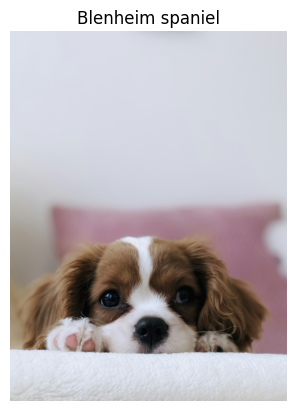

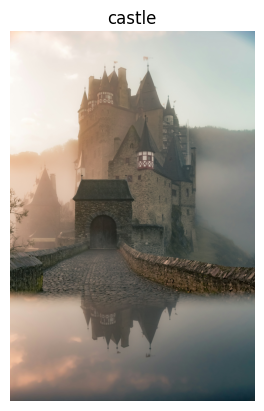

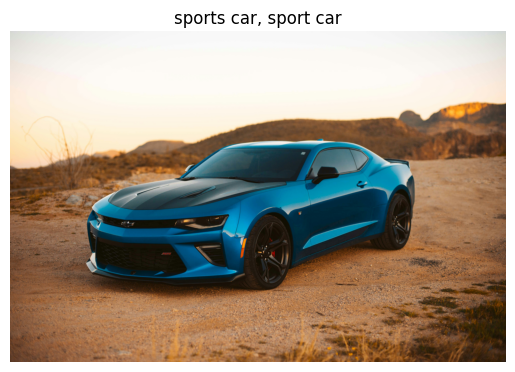

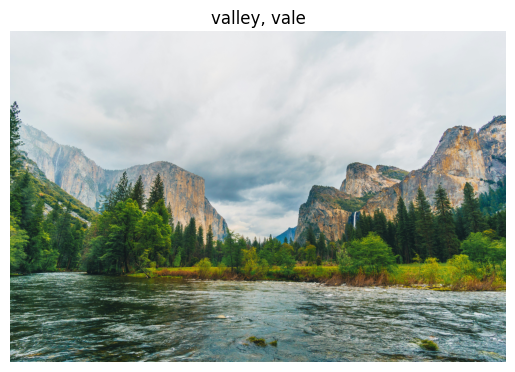

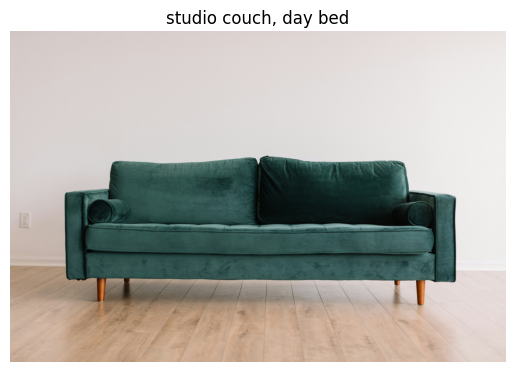

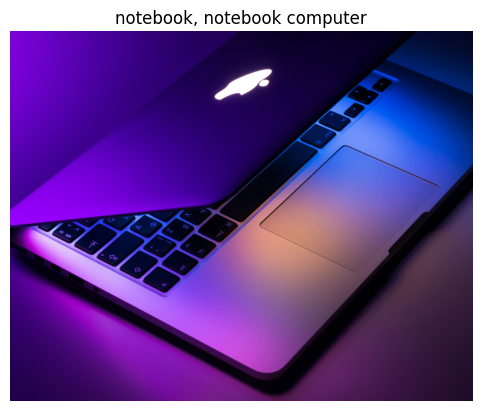

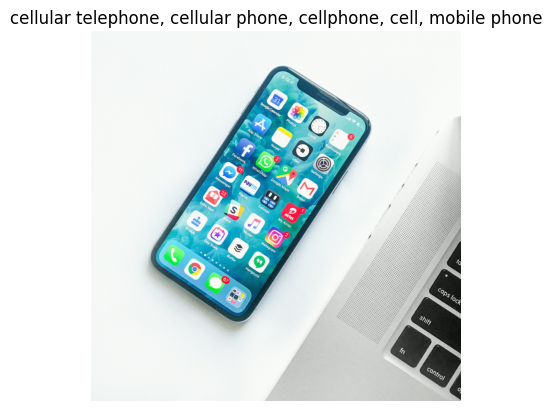

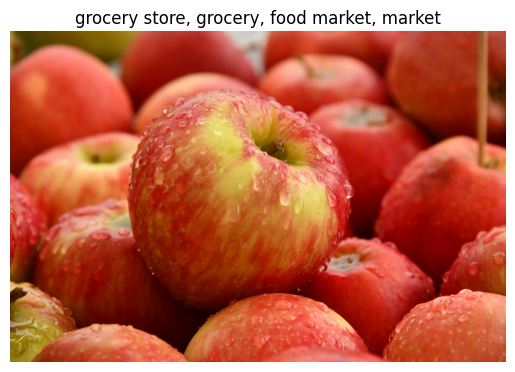

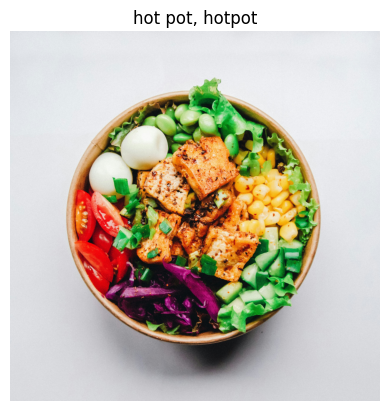

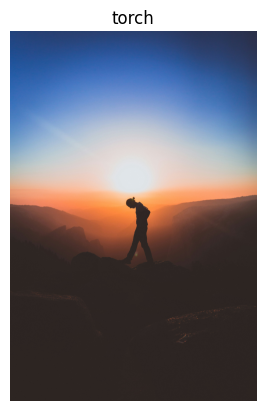

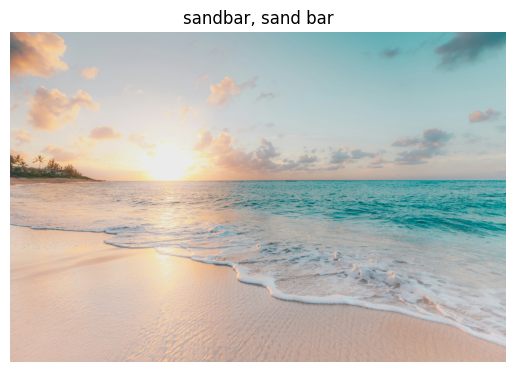

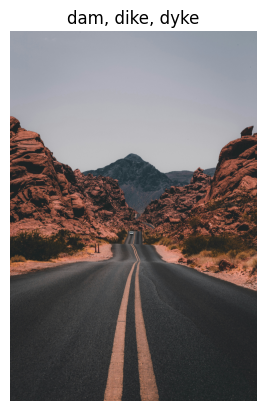

In [2]:
resnet_model_name = "microsoft/resnet-50"
# load the feature extractor: an object that preprocesses an image and extracts its features to be used with the model
img_feature_extractor = AutoFeatureExtractor.from_pretrained(resnet_model_name)
# load the resnet model
resnest_model = TFAutoModelForImageClassification.from_pretrained(resnet_model_name)

# we classify the images from images.image_URLs
for url in images.image_URLs:
    # Preprocess the image
    image = Image.open(requests.get(url, stream=True).raw)
    # get the features of the image
    inputs = img_feature_extractor(images=image, return_tensors="tf")
    # Perform inference with the trained model
    outputs = resnest_model(**inputs)
    # get the probability of each class (softmax) a.k.a. the logits
    logits = outputs.logits
    # get the predicted class (the index of the value with the highest probability)
    predicted_class_idx = tf.argmax(logits, axis=-1).numpy()[0]
    # get the name of the predicted class
    label = resnest_model.config.id2label[predicted_class_idx]
    # display the image with the predicted class as the title
    plt.imshow(image)
    plt.title(label)
    plt.axis("off")
    plt.show()

## Object detection

[Object detection](https://en.wikipedia.org/wiki/Object_detection) is a computer vision task that involves identifying and localizing objects within an image or video. Convolutional Neural Networks (CNNs) have become a foundational technology for this task due to their ability to learn hierarchical feature representations from images. Unlike traditional methods that focus solely on classification, CNN-based object detection models not only classify objects but also predict their locations in the form of bounding boxes. This dual capability is crucial for applications like autonomous driving, surveillance, and image analysis.

One of the most popular architectures for real-time object detection is [YOLO (You Only Look Once)](https://en.wikipedia.org/wiki/You_Only_Look_Once). YOLO treats object detection as a single regression problem, predicting bounding boxes and class probabilities simultaneously from the entire image. The model divides the image into a grid and assigns bounding boxes and confidence scores to each grid cell for the objects it detects. This approach allows YOLO to achieve impressive speed and accuracy, making it suitable for applications requiring quick responses, such as video surveillance and real-time tracking.

The following example shows the use of a YOLOv8 model fine-tuned for plane detection. The model is loaded from Hugging Face, and we use it to detect planes in images from the Internet. This model could be used for assisting in air traffic control tasks and airport security.

config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

best.pt:   0%|          | 0.00/52.0M [00:00<?, ?B/s]

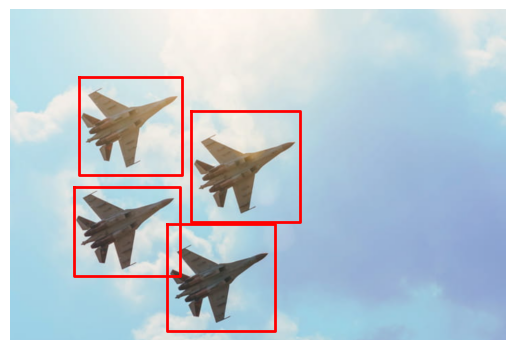

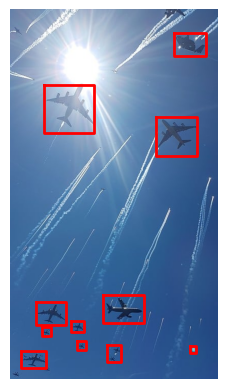

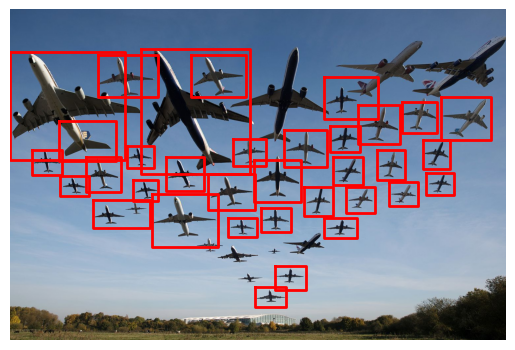

In [3]:
# load model from hugging face
model = YOLO('keremberke/yolov8m-plane-detection')

# set YOLO model parameters
model.overrides['conf'] = 0.25  # NMS (Non-Maximum Suppression) confidence threshold (0-1). NMS is a technique used to filter out overlapping bounding boxes.
model.overrides['iou'] = 0.45  # NMS IoU (Intersection over Union) threshold
model.overrides['agnostic_nms'] = False  # NMS class-agnostic means that the NMS will be applied independently to each class
model.overrides['max_det'] = 1000  # maximum number of detections per image

# we detect the planes in the images from images.plane_image_URLS
for image_URL in images.plane_image_URLS:
    # perform inference (detect the bounding boxes of planes)
    results = model.predict(image_URL)
    # visualize the image and the bounding boxes
    image = Image.open(requests.get(image_URL, stream=True).raw)
    plt.imshow(image)
    for box in results[0].boxes:
        # get the coordinates of the bounding box (x1, y1, x2, y2)
        x1, y1, x2, y2 = list(box.xyxy[0].numpy())
        plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], color='red', lw=2)
    plt.axis("off")
    plt.show()

## Image segmentation

[Image segmentation](https://en.wikipedia.org/wiki/Image_segmentation) is a computer vision technique that involves dividing an image into multiple segments or regions, making it easier to analyze and process. The goal is to simplify the representation of an image by identifying and isolating objects or areas of interest within it. Each segment, region or pixel is assigned a unique label, allowing for easier interpretation and analysis of the image. Image segmentation is used in a variety of applications across different fields, including medical imaging (e.g., organ and tumor detection in RMI images), autonomous vehicles (e.g., object detection and tracking), satellite imaging (e.g., smoke detection in forest fires), and augmented reality (e.g., object recognition and tracking).

Image segmentation can be performed using a variety of techniques, including CNNs (Convolutional Neural Networks). In the following example, we will use a model for image segmentation using the deep [Segformer architecture](https://huggingface.co/docs/transformers/model_doc/segformer). The [`mattmdjaga/segformer_b2_clothes`](https://huggingface.co/mattmdjaga/segformer_b2_clothes) model is fine-tuned on the [ATR dataset](https://github.com/lemondan/HumanParsing-Dataset) for clothes segmentation but can also be used for human segmentation. It detects the following 18 classes and segments the image accordingly: `Background`, `Hat`, `Hair`, `Sunglasses`, `Upper-clothes`, `Skirt`, `Pants`, `Dress`, `Belt`, `Left-shoe`, `Right-shoe`, `Face`, `Left-leg`, `Right-leg`, `Left-arm`, `Right-arm`, `Bag`, `Scarf`.

preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.73k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/109M [00:00<?, ?B/s]

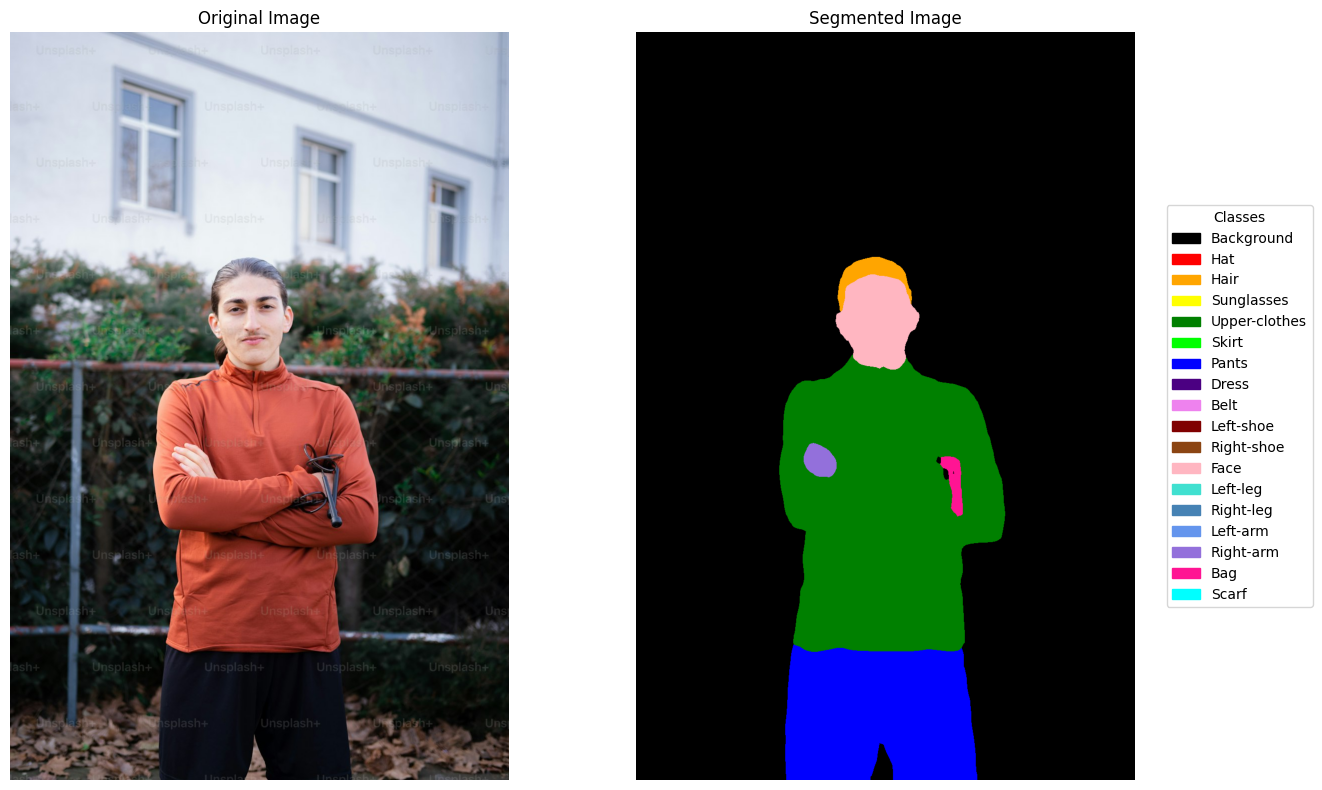

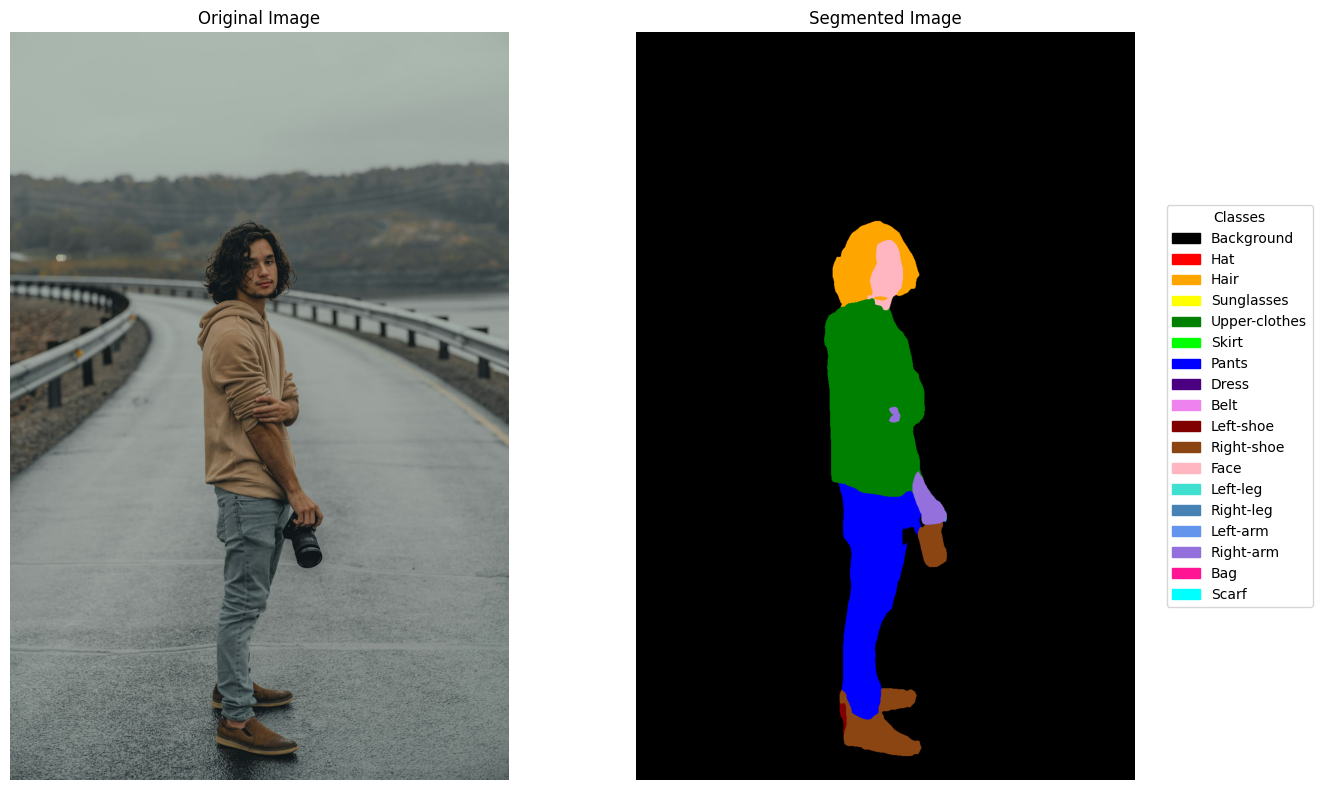

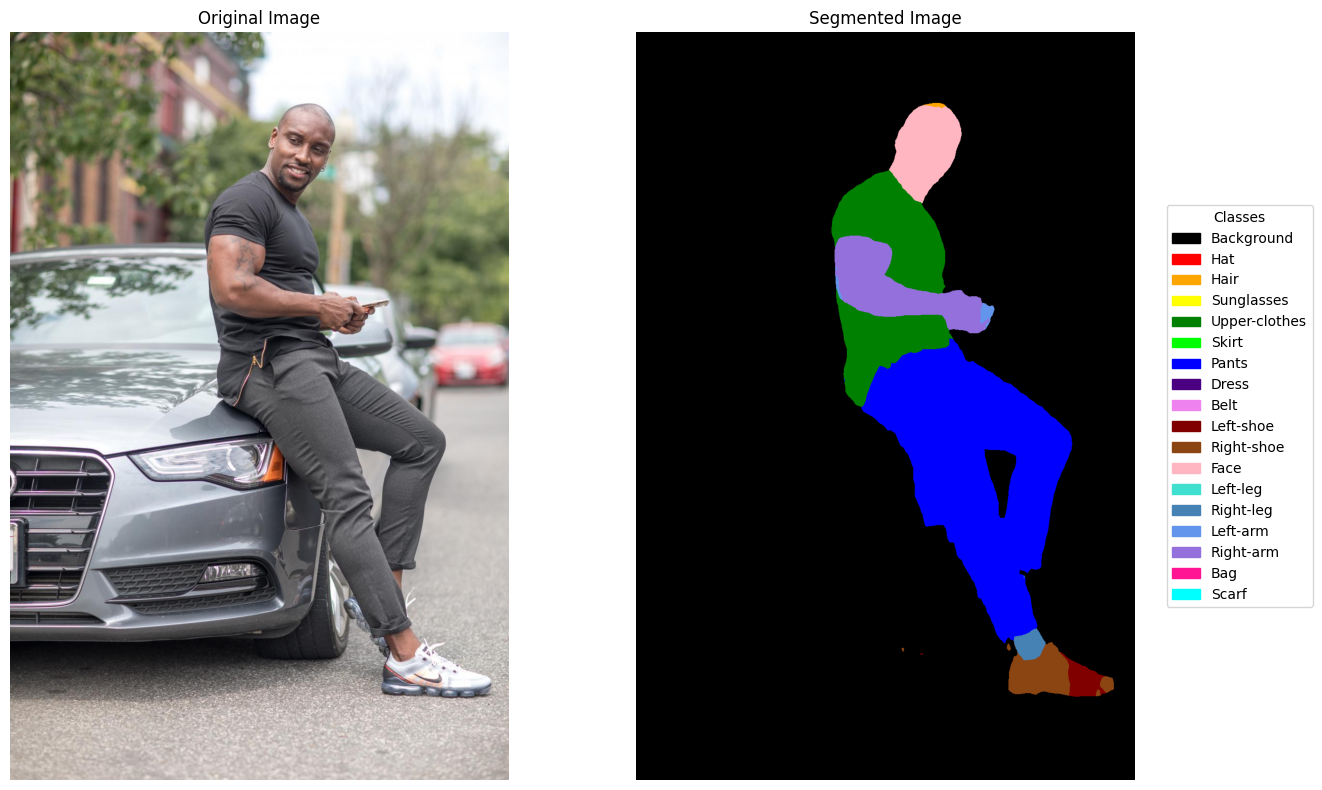

In [4]:
# model_name from Hugging Face
model_name = 'mattmdjaga/segformer_b2_clothes'
# the processor takes an input image and returns a tensor
processor = SegformerImageProcessor.from_pretrained(model_name)
# load the model performs the segmentation
model = AutoModelForSemanticSegmentation.from_pretrained(model_name)

# process each image in the list
for image_url in images.segmentation_image_URLs:
    # get the input features from the image
    image = Image.open(requests.get(image_url, stream=True).raw)
    inputs = processor(images=image, return_tensors="pt")
    # perform segmentation with the model
    outputs = model(**inputs)
    logits = outputs.logits  # get the logits (probabilities for each class) from the output
    # We take the output of the CNN and upsample it to the original image size.
    # That is, we resize the output to the original image size, because the CNN output is smaller than the input image.
    # We use bilinear interpolation to upsample the logits.
    # Then, we will get, for each pixel, the class with the highest probability.
    upsampled_logits = nn.functional.interpolate(logits, size=image.size[::-1], mode="bilinear", align_corners=False)
    # we take the class with the highest probability for each pixel
    segmentation_prediction = upsampled_logits.argmax(dim=1)[0].numpy()
    # Plot the original image and the segmentation mask
    utils.plot_image_segmentation(segmentation_prediction, image, images.class_labels, images.color_mapping)